# User Churn Analysis for Subscription-Based Services
by Biel Anthony Benito, MBA

### Overview
This is my Exploratory Data Analysis (in Python) of a dataset provided by Web Search and Data Mining (WSDM) from KKBOX - a music streaming service in Asia.  When users sign up for the subscription-based service, they can then choose to renew their membership either manually or via an auto-renew preference with the option to cancel at any time.

For a subscription business, accurately predicting churn is critical to long-term success. Even slight variations in churn can drastically affect profits.  Therefore, the overall goal is to build an algorithm that predicts whether a user will churn after their subscription expires based on the analysis of user attributes and behavior on the website.


### Data Description

train.csv - the train set, containing the user ids and whether they have churned.
    
    -msno:  This is the user id
    -is_churn:  This is the target variable. Churn is defined as whether the user did not continue the subscription 
                within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

transactions.csv

    -msno:  user id
    -payment_method_id:  payment method
    -payment_plan_days:  length of membership plan in days
    -plan_list_price:  in New Taiwan Dollar (NTD)
    -actual_amount_paid:  in New Taiwan Dollar (NTD)
    -is_auto_renew:  membership auto-renewal option
    -transaction_date:  format %Y%m%d
    -membership_expire_date:  format %Y%m%d
    -is_cancel:  whether or not the user canceled the membership in this transaction.

user_logs.csv

    -msno:  user id
    -date:  format %Y%m%d
    -num_25:  # of songs played less than 25% of the song length
    -num_50:  # of songs played between 25% to 50% of the song length
    -num_75:  # of songs played between 50% to 75% of of the song length
    -num_985:  # of songs played between 75% to 98.5% of the song length
    -num_100:  # of songs played over 98.5% of the song length
    -num_unq:  # of unique songs played
    -total_secs:  total seconds played

members.csv

    -msno:  user id
    -city:  user city
    -bd:  age (Note: this column has outlier values ranging from -7000 to 2015, please use your judgement)
    -gender  user gender
    -registered_via:  registration method
    -registration_init_time:  format %Y%m%d


### Read / Load in the datasets

In [1]:
#Basic Modules/Packages used and required
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale

#Visualization Modules/Packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.mlab as mlab
from matplotlib.gridspec import GridSpec
from IPython.core.display import display
from IPython.core.interactiveshell import InteractiveShell

#Read / Load Datasets
train = pd.read_csv('train.csv')
transactions = pd.read_csv('transactions.csv')
user_logs = pd.read_csv('user_logs.csv')
members = pd.read_csv('members.csv')
test = pd.read_csv('sample_submission.csv')

#Activate tf and monitor performance
import sys
import tensorflow as tf
from datetime import datetime, timedelta
#device_name="/gpu:0"

#Python Extras / Helpful extensions
InteractiveShell.ast_node_interactivity = "all"     #Display outputs w/out print statement

### Exploratory Data of the 'members.csv' dataset

In [2]:
#'members.csv' at a glance
members.shape
members.info()
members.isnull().sum().sort_values()

InteractiveShell.ast_node_interactivity = "last_expr"

(6769473, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
msno                      object
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    int64
dtypes: int64(4), object(2)
memory usage: 309.9+ MB


msno                            0
city                            0
bd                              0
registered_via                  0
registration_init_time          0
gender                    4429505
dtype: int64

C:\Users\Bunny\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


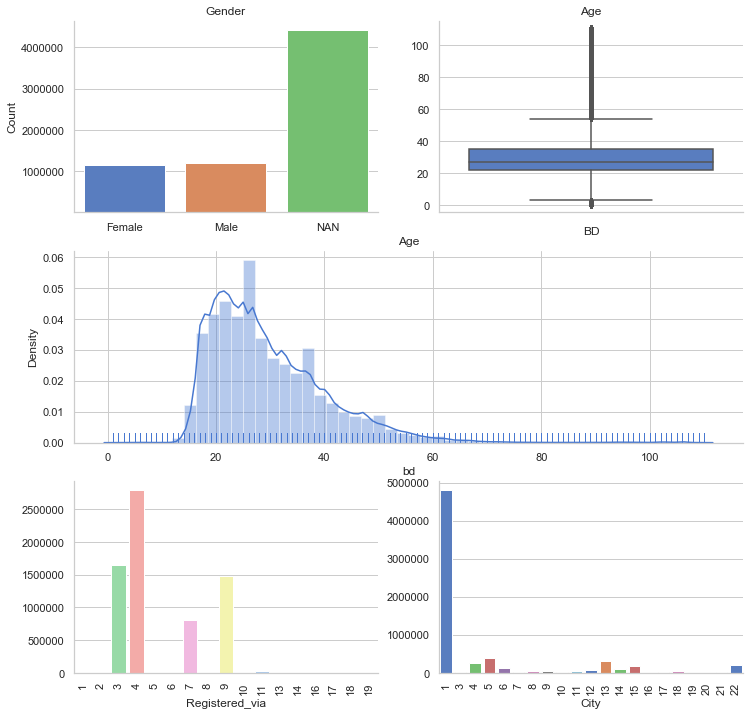

In [3]:
#Plot 'Members.csv':  Gender, BD (Box & Dist), City, Reg_via
fig = plt.figure(figsize=(12, 12))
gs=GridSpec(3,2) # 1 rows, 2 columns
sns.set(style="whitegrid", palette="muted", color_codes=True)


# Plot of 'Gender' - 1st row, 1st column
num_male = members['gender'].value_counts()['male']
num_female = members['gender'].value_counts()['female']
num_nan = members['gender'].isnull().sum() #NANs for Gender

ax1=fig.add_subplot(gs[0,0]) # 1st row, 1st column
sns.barplot(x=['Female', 'Male', 'NAN'], y=[num_female, num_male, num_nan])
ax1.set_title('Gender')
ax1.set_ylabel('Count')
ax1.set(yticks=[1000000,2000000,3000000,4000000])


# Plot of 'Age' as Box - 1st row, 2nd column
temp_bd = members.bd.apply(lambda x: 999 if ((int(x)<1) | (int(x)>110)) else x).astype('int')
temp_bd = temp_bd[(temp_bd != "NAN") & (temp_bd != 999)]  #Remove non-numeric and set outliers (NANs and 999s)
ax2=fig.add_subplot(gs[0,1]) # 1st row, 2nd column
sns.boxplot(y=temp_bd)
ax2.set_title('Age')
ax2.set_xlabel('BD')
ax2.set_ylabel('')


# Plot of 'Age' as Dist - 2nd row, span column
ax3=fig.add_subplot(gs[1,:]) # 2nd row, span all columns
sns.distplot(temp_bd, rug=True)
ax3.set_title('Age')
ax3.set_ylabel('Density')


# Plot of 'Registered_via'
temp_reg = members
temp_reg = temp_reg.drop(temp_reg.index[3335942])
ax4=fig.add_subplot(gs[2,0]) # 3rd row, 1st column
sns.set(style="whitegrid", palette="muted", color_codes=True)
#cities = members.city.sort_values("city", ascending=False)
sns.countplot(x='registered_via', data=temp_reg, palette="pastel", label="registered_via", color="b")
ax4.set(ylabel="", xlabel="Registered_via")
loc, labels = plt.xticks()
ax4.set_xticklabels(labels, rotation=90)


# Plot of 'City'
sns.set(style="whitegrid", palette="muted", color_codes=True)
ax5=fig.add_subplot(gs[2,1]) # 3rd row, 2nd column
sns.countplot(x='city', data=members, palette="muted", label="city", color="b")
ax5.set(ylabel="", xlabel="City")
loc, labels = plt.xticks()
ax5.set_xticklabels(labels, rotation=90)


sns.despine()
plt.show()

del temp_bd, temp_reg     #memory clean

### Observations / Possible Assumptions:     'members.csv'
Gender:
    - It almost seems like an even spit between male & females with the only difference being 
      (50,742 - less than 1% of the total).
    - The majority comes to about 65%, which can be viewed as either undisclosed, missing, or NAN.
      Note: Begin to consider how to handle these values - may affect our prediction model later.

BD/Age:
    - Post cleaning and narrowing the window to realistic ages between 0-110, we have removed
      all the outiers and NANs out of the picture.
    - The birth date data shows a positive skew starting with teenagers and peaking at 
      the median group estimating towards 28 yr olds.

Registered_via:
    - In order, the top registration methods (4, 9, 3, 7) dominate the group as most popular.

City:
    - Out of 21 cities, City-1 unanimously has the most users. 
    - Some possible reasons maybe, but not limited to:
      being the most populated area, most marketed for advertisements, 
      most developed city with a demographics mostly of college and young professions, etc.


### Exploratory Data of the 'transactions.csv' dataset

In [4]:
#'transactions.csv' at a glance
transactions.shape
transactions.info()
transactions.isnull().sum().sort_values()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 9 columns):
msno                      1431009 non-null object
payment_method_id         1431009 non-null int64
payment_plan_days         1431009 non-null int64
plan_list_price           1431009 non-null int64
actual_amount_paid        1431009 non-null int64
is_auto_renew             1431009 non-null int64
transaction_date          1431009 non-null int64
membership_expire_date    1431009 non-null int64
is_cancel                 1431009 non-null int64
dtypes: int64(8), object(1)
memory usage: 98.3+ MB


msno                      0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
dtype: int64

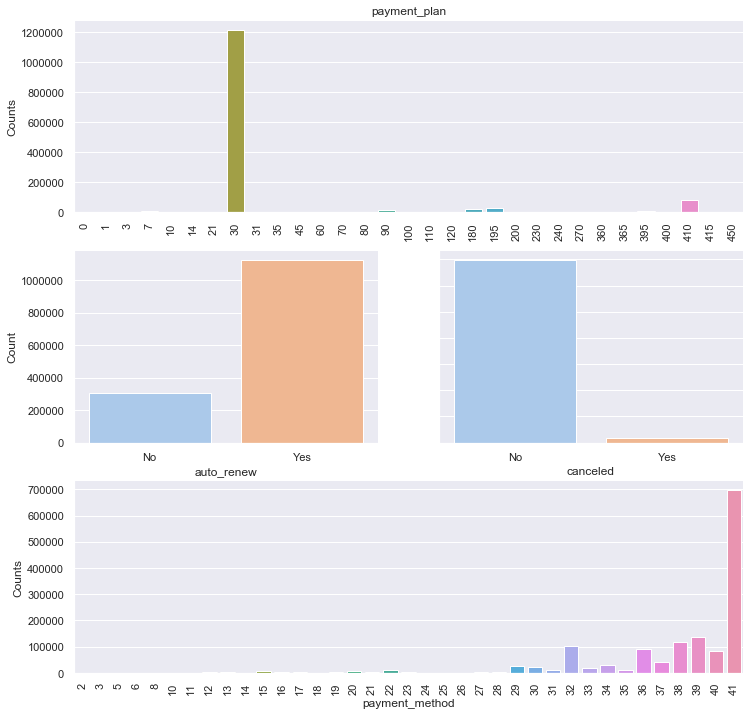

In [5]:
#Plot 'Transactions.csv':  Payment_method, Payment_plan, Auto_renew, Is_cancel
fig = plt.figure(figsize=(12, 12))
gs=GridSpec(3,2) # 1 rows, 2 columns
sns.set(style="darkgrid", palette="pastel", color_codes=True)


# Plot of 'Payment_plan' - 1st row, span all columns
ax1=fig.add_subplot(gs[0,:])
sns.countplot(x='payment_plan_days', data=transactions, label='payment_plan')
ax1.set(xlabel="", ylabel='Counts')
loc, labels = plt.xticks()
ax1.set_xticklabels(labels, rotation=90)
ax1.set_title('payment_plan')


# Plot of 'auto_renew' - 2nd row, 1st column
ax2=fig.add_subplot(gs[1,0])
num_auto_no = len(transactions.is_auto_renew[transactions.is_auto_renew == 0])
num_auto_yes = len(transactions.is_auto_renew[transactions.is_auto_renew == 1])
sns.barplot(x=['No', 'Yes'], y=[num_auto_no, num_auto_yes])
ax2.set_xlabel('auto_renew')
ax2.set_ylabel('Count')


# Plot of 'is_cancel' - 2nd row, 2nd column
ax3=fig.add_subplot(gs[1,1]) 
num_cancel_no = len(transactions.is_cancel[transactions.is_cancel == 0])
num_cancel_yes = len(transactions.is_cancel[transactions.is_cancel == 1])
sns.barplot(x=['No', 'Yes'], y=[num_cancel_no, num_cancel_yes])
ax3.set_xlabel('canceled')
ax3.set(yticklabels=[])


# Plot of 'payment_method_id' - 3rd row, span all columns
ax4=fig.add_subplot(gs[2,:]) 
sns.countplot(x='payment_method_id', data=transactions, label='payment_method')
ax4.set(ylabel='Counts', xlabel="payment_method")
loc, labels = plt.xticks()
ax4.set_xticklabels(labels, rotation=90)

sns.despine()
plt.show()

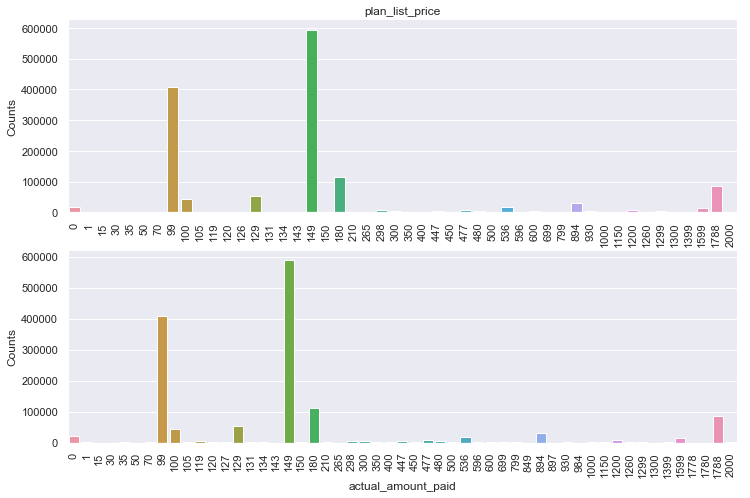

In [6]:
#Plot 'Transactions.csv':  Payment_method, Payment_plan, Auto_renew, Is_cancel
fig = plt.figure(figsize=(12, 12))
gs=GridSpec(3,2) # 1 rows, 2 columns
sns.set(style="darkgrid", palette="muted", color_codes=True)


# Plot of 'Plan_list_price' - 1st row, span all columns
ax1=fig.add_subplot(gs[0,:])
sns.countplot(x='plan_list_price', data=transactions, label='plan_list_price')
ax1.set(xlabel="plan_list_price", ylabel='Counts')
ax1.set_title('plan_list_price')
loc, labels = plt.xticks()
ax1.set_xticklabels(labels, rotation=90)


# Plot of 'Actual_amount_paid' - 2nd row, span all columns
ax2=fig.add_subplot(gs[1,:])
sns.countplot(x='actual_amount_paid', data=transactions, label='actual_amount_paid')
ax2.set(xlabel="actual_amount_paid", ylabel='Counts')
ax2.set_title('')
loc, labels = plt.xticks()
ax2.set_xticklabels(labels, rotation=90)

sns.despine()
plt.show()


In [7]:
# Simple query to calculate the overall balance (paid off vs still owed)
temp_balance = (transactions.plan_list_price - transactions.actual_amount_paid)
print("Total actual amount overpaid:  " + str(temp_balance[temp_balance < 0].sum()))
print("Total amount still owed:       " + str(temp_balance[temp_balance > 0].sum()))
print("_______________________________________")
print("Total balance (still owed):    " + str(temp_balance.sum()))

del temp_balance     #memory clean

Total actual amount overpaid:  -362997
Total amount still owed:       1035276
_______________________________________
Total balance (still owed):    672279


### Observations / Possible Assumptions:     'transactions.csv'
    
Payment_plan_id:
    - Out of the 31 possible payment plans, the 30-day subscription seems to be the most popular,
      which is not surprising as the monthly subscription is the most common.  

Payment_method_id:
    - There are 37 payments types available with pay method 41 being the median choice.

Is_auto_renew:
    - About 80% of current users are set for auto_renew.  

Is_cancel:
    - It seems only about 2.5% of transactions are cancellation of the service - A good sign!


### Exploratory Data of the 'user_logs.csv' dataset

In [8]:
#'user_logs.csv' at a glance
user_logs.shape
user_logs.info()
user_logs.isnull().sum().sort_values()
user_logs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18396362 entries, 0 to 18396361
Data columns (total 9 columns):
msno          object
date          int64
num_25        int64
num_50        int64
num_75        int64
num_985       int64
num_100       int64
num_unq       int64
total_secs    float64
dtypes: float64(1), int64(7), object(1)
memory usage: 1.2+ GB


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


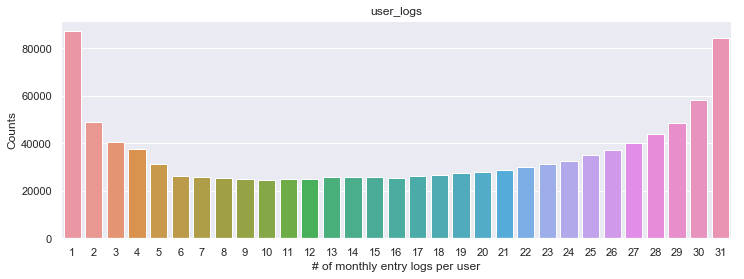

In [9]:
InteractiveShell.ast_node_interactivity = "last_expr"

#Plot the '# of monthly entry logs per user' from 'user_logs.csv'
fig, ax = plt.subplots(figsize=(12,4))
sns.set(style="whitegrid", palette="deep", color_codes=True)

x = sorted(user_logs.msno.value_counts().unique())
y = ((user_logs.msno.value_counts()).value_counts().sort_index()).tolist()
sns.barplot(x=x, y=y)
ax.set_title('user_logs')
ax.set_xlabel('# of monthly entry logs per user')
ax.set_ylabel('Counts')

plt.show()

### Observations / Possible Assumptions: 'user_logs.csv'

In [11]:
#***Below are some exploratory queries for the columns of 'user_logs.csv'

print("Total number of (unique) users in 'user_logs.csv':  " + str(len(user_logs.msno.unique())) )

#Averages per user
print('Avg activity log entries per user: ' + str(user_logs.msno.value_counts().mean()) )
print('Avg song(s) played: ')
print('         less than 25% of the song length: ' + str(user_logs.num_25.mean()) )
print('         between 25-50% of the song length: ' + str(user_logs.num_50.mean()) )
print('         between 50-75% of the song length: ' + str(user_logs.num_75.mean()) )
print('         between 75-98.5% of the song length: ' + str(user_logs.num_985.mean()) )
print('         over 98.5% of the song length: ' + str(user_logs.num_100.mean()) )
print('Avg # of unique songs played:  ' + str(user_logs.num_unq.mean()) )
print('Avg total of seconds of music played:  ' + str(user_logs.total_secs.mean()) )


Total number of (unique) users in 'user_logs.csv':  1103894
Avg activity log entries per user: 16.664971455592656
Avg song(s) played: 
         less than 25% of the song length: 6.191400941120858
         between 25-50% of the song length: 1.5087888572751504
         between 50-75% of the song length: 0.9413759089976594
         between 75-98.5% of the song length: 1.0799049290289027
         over 98.5% of the song length: 30.28246090178047
Avg # of unique songs played:  29.03614551616238
Avg total of seconds of music played:  7904.81355635866


Notes:
    - The amount of users have a direct relationship with the duration of a song
    - The amount of songs played entirety increase with the duration through the song
    - An avg user listens to about 30 songs in its entirety.
      (That translate to about 260 songs; Estimated at 2 hours and 12 mins of listening time)
    - Most songs that get stopped/skipped occur after being played 75% of the way through

### Building a customized training set  

In [34]:
InteractiveShell.ast_node_interactivity = "all"

#Create my own dataset by merging all available datasets for a baseline 
my_train = train.copy()     #Start with the training set.csv'

#Prior to merging, proactively prevent duplicates with a funtion to consoidate rows of the same 'msno' into one from the median of all 
def add_column(df1, df2, columns):
    temp = df2.groupby('msno')[columns].median().astype(int).reset_index()
    df1 = df1.merge(temp, how='left', on='msno')
    return (df1)


#Merge in select columns from each dataset
my_train = add_column(my_train, transactions, ['payment_method_id', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'is_auto_renew', 'is_cancel'])
my_train = add_column(my_train, user_logs, ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs'])
my_train = add_column(my_train, members, ['city', 'registered_via'])


#Add gender separately as str for NaN values (from members)
temp_gender = members.groupby('msno').gender.first().astype(str).reset_index()  
my_train = my_train.merge(temp_gender, how='left', on='msno')


##'''Add only the following columns from each dataset listed below:  
#     members
#         - city
#         - gender  (add separately)
#         - registered_via
#     transactions
#         - payment_method_id
#         - payment_plan_days
#         - plan_list_price
#         - actual_amount_paid
#         - is_auto_renew
#         - is_cancel
#     user_logs
#         - avg all columns  
#
#     ***new features to consider later for hyperparameter optimization
#         - activity days before expiration  (transaction)
#         - amount of entries  (user_logs)
#         - amount of registration  (members)
#'''

my_train.head()  #Inspect

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,registered_via,gender
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,0.0,21.0,17.0,7198.0,5.0,3.0,male
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,36.0,30.0,180.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,1336.0,13.0,3.0,male
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,16.0,75.0,150.0,150.0,0.0,0.0,5.0,2.0,1.0,1.0,4.0,12.0,1637.0,13.0,3.0,male
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41.0,30.0,149.0,149.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,7.0,nan
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,41.0,30.0,99.0,99.0,1.0,0.0,0.0,0.0,0.0,0.0,53.0,36.0,12745.0,13.0,7.0,female


### Addition EDA of 'user_logs.csv' post-consolidation 

C:\Users\Bunny\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Bunny\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'num_songs breakdown')

Text(0.5, 0, '# of songs played by duration')

Text(0, 0.5, 'Density')

(0, 40)

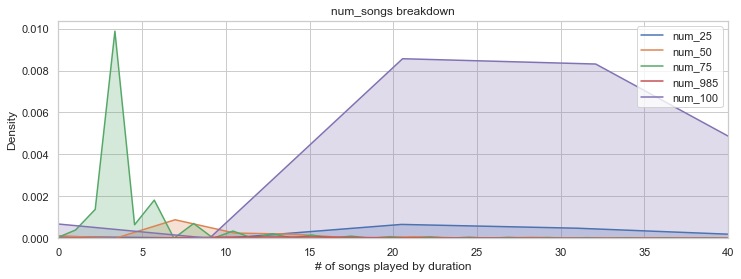

In [20]:
#Plot of the 'num_songs' from 'user_logs.csv'
fig, ax = plt.subplots(figsize=(12,4))
sns.set(style="whitegrid", palette="deep", color_codes=True)

x = sorted(my_train.num_25.value_counts().unique())
y = ((my_train.num_25.value_counts()).value_counts().sort_index()).tolist()
sns.distplot(my_train.num_25, hist=False, kde_kws={"shade": True}, label='num_25')
sns.distplot(my_train.num_50, hist=False, kde_kws={"shade": True}, label='num_50')
sns.distplot(my_train.num_75, hist=False, kde_kws={"shade": True}, label='num_75')
sns.distplot(my_train.num_985, hist=False, kde_kws={"shade": True}, label='num_985')
sns.distplot(my_train.num_100, hist=False, kde_kws={"shade": True}, label='num_100')
ax.set_title('num_songs breakdown')
ax.set_xlabel('# of songs played by duration')
ax.set_ylabel('Density')
ax.set_xlim(0, 40)

plt.legend()
plt.show()

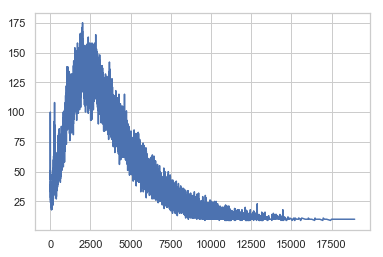

In [22]:
#Visual/Plot for the majority of 'total_secs' 
sns.lineplot(data=my_train.total_secs.value_counts().head(12000))

In [35]:
#Churn query analysis for 'payment_plan_days'
days = [1, 7, 30, 60, 90, 120, 180, 240, 360]
print('The possibility of churn (in days): ')
for day in days:
    churn = len(my_train[(my_train.payment_plan_days == day) & (my_train.is_churn == 1)])
    churn_total = len(my_train[(my_train.payment_plan_days == day)]) 
    print(str(day) + '-Day Plan is ' + str(churn/churn_total) + '%')


The possibility of churn (in days): 
1-Day Plan is 0.8709677419354839%
7-Day Plan is 0.7692307692307693%
30-Day Plan is 0.04396797839295411%
60-Day Plan is 0.70521327014218%
90-Day Plan is 0.9972952086553323%
120-Day Plan is 0.9856733524355301%
180-Day Plan is 1.0%
240-Day Plan is 0.985%
360-Day Plan is 1.0%


Notes: The following observation can be derived from the simple query above:
    - About 75-90% so trial members will churn between the 1-Day and 1-Week trials
    - A 30-Day plan will retain about 96% of subscribers
    - The 60-Day mark shows a big drop in user down to 32% retention
    - Almost 100% of users churn after 90-Days

My assumption is that upon the end of their 1-Month trial, users maybe taking advantage of a possible marketing promotion as a hook for the next (2) months. Afterwards, they might be cancelling after the 3rd month just to re-registering and get the same deal again.  Plausible?

In [36]:
#Drill down to compare user behaviors that selected the 90-Day Payment Plan 
my_train[(my_train.payment_plan_days == 90) & (my_train.is_churn == 1)]   #Consists of 99%+
my_train[(my_train.payment_plan_days == 90) & (my_train.is_churn == 0)]   #Is less than 1%

#Notable differences at glance is the price point:  Churn users paid $477 compared to the $300 of those who stayed

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,registered_via,gender
55,ogP6gr6Fr9GAkLEXgMYtypFcTOHudzJrCD/VDnhR6w8=,1,38.0,90.0,477.0,477.0,0.0,0.0,2.0,0.0,0.0,0.0,30.0,35.0,7166.0,13.0,3.0,male
61,prdUZGxqqZsogFuP8mUe+2ty4g2lsXn7wHtIMJUqPV8=,1,38.0,90.0,447.0,447.0,0.0,0.0,3.0,1.0,1.0,1.0,57.0,58.0,16204.0,15.0,3.0,female
62,07BqZinAC48xGnZjsnufxMnduRW0M3Tcs7hTK62ygTs=,1,38.0,90.0,477.0,477.0,0.0,0.0,5.0,0.0,0.0,0.0,19.0,27.0,4996.0,22.0,3.0,female
158,xohhVdfD6gcOzrt3BL4GSEozogsOeyl5/yGGUnhlZRw=,1,38.0,90.0,477.0,477.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,34.0,9714.0,22.0,4.0,male
162,74dp0Elxq6CaWeFhlG6kIE0LQWdJ+S8l8l76FvpD7mQ=,1,38.0,90.0,477.0,477.0,0.0,0.0,8.0,1.0,1.0,1.0,15.0,16.0,4784.0,1.0,4.0,nan
205,nVCRZxcwpzMfx8OAtRsMQINKKjWFELp21ogjq2yqfsA=,1,38.0,90.0,477.0,477.0,0.0,0.0,7.0,2.0,2.0,1.0,6.0,14.0,2862.0,1.0,9.0,nan
254,ggAiNn7ZyKL1E8RbZxO90Fp8Ct0VT+q4R3TOaYLF7gc=,1,38.0,90.0,477.0,477.0,0.0,0.0,2.0,1.0,0.0,1.0,8.0,15.0,3336.0,4.0,9.0,female
287,maevuKjXxz8i9HZ9jiquyjlAomoFQaJGcxvKik47Hzg=,1,32.0,90.0,149.0,149.0,0.0,0.0,5.0,1.0,1.0,1.0,34.0,37.0,8540.0,22.0,9.0,female
389,2sktZQngTcVriCMjo2o/3XMOzN+0jWtCBdjG2H4gKiI=,1,38.0,90.0,447.0,447.0,0.0,0.0,7.0,1.0,0.0,1.0,11.0,17.0,3312.0,1.0,3.0,nan
430,COjqRX8neymhEES8G2B6LwuW1JrpPTz2ywmVCGq/ghA=,1,38.0,90.0,477.0,477.0,0.0,0.0,2.0,1.0,0.0,1.0,17.0,21.0,4692.0,12.0,3.0,male


,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,registered_via,gender
54979,jF245nac2uUwfnd0bwfLbqWu6OSUrMplGgz8rxOvyOA=,0,15.0,90.0,300.0,300.0,0.0,0.0,10.0,2.0,2.0,2.0,18.0,23.0,6160.0,13.0,4.0,male
260589,oN0C7moN0HHtARv1WSg7v6m+NVRDOfRlt1E4xk5d670=,0,32.0,90.0,300.0,300.0,0.0,0.0,11.0,1.0,1.0,5.0,14.0,23.0,5418.0,22.0,3.0,male
311484,zthquhnCuA/aL6e9TE4CC9MHy9+u5M/a7Br8q/vzuw8=,0,38.0,90.0,477.0,477.0,0.0,0.0,2.0,1.0,0.0,0.0,59.0,38.0,14150.0,13.0,4.0,female
356625,F0yRtYECEO9EdHRDEGgOpP/a01vyf558HA0CRxz9s3c=,0,15.0,90.0,300.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6.0,1434.0,1.0,4.0,nan
400443,4SonOLdVLeeBOsgkidgcV7O+nt55wWlGwG4hMRBuH+M=,0,15.0,90.0,300.0,300.0,0.0,0.0,4.0,0.0,0.0,1.0,10.0,11.0,2507.0,1.0,9.0,nan
461672,oFAhrtdqzCKhQao8OQ84QL5Oa96suJLwc7kux2Hpyao=,0,15.0,90.0,300.0,300.0,0.0,0.0,1.0,0.0,0.0,0.0,15.0,15.0,3597.0,4.0,4.0,female
723736,d8S2LkffgILKmCqAGrD7+sT6QzkPZPHTBVofz7BHZBs=,0,32.0,90.0,298.0,298.0,0.0,0.0,5.0,1.0,0.0,1.0,64.0,62.0,16723.0,15.0,9.0,female


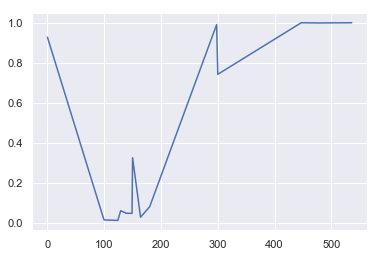

In [38]:
#Drill down query to analyze user (churn) reaction to price points
list_price = [0, 99, 100, 124, 129, 139, 149, 150, 164, 180, 298, 300, 447, 477, 536]  #Top 15 value counts for 'plan_list_price' (sort)
list_percent = []
for price in list_price:
    churn = len(my_train[(my_train.plan_list_price == price) & (my_train.is_churn == 1)])
    churn_total = len(my_train[(my_train.plan_list_price == price)]) 
    #print(str(price) + '-List Price is ' + str(churn/churn_total) + '%')
    list_percent.append(churn/churn_total)
list_percent = [0.928, 0.0195, 0.0139, 0.0114, 0.0599, 0.0471, 0.04665, 0.3248, 0.0276, 0.0794, 0.9907, 0.742, 1.0, 0.999, 1.0]
sns.set(style="darkgrid")
sns.lineplot(x=list_price, y=list_percent)

#NOTE:  Users seem to be sensitive to plan_list_prices with a turning point at about $200

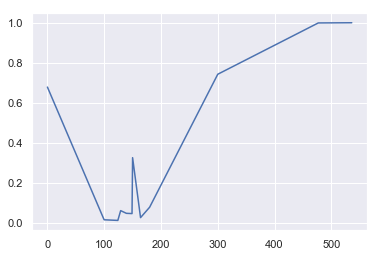

In [39]:
#Drill down query to analyze user (churn) reaction to actual_amount_paid
amount_paid = [0, 99, 100, 124, 129, 139, 149, 150, 164, 180, 300, 477, 536]  #Top 15 value counts for 'plan_list_price' (sort)
paid_percent = []
for price in amount_paid:
    churn = len(my_train[(my_train.actual_amount_paid == price) & (my_train.is_churn == 1)])
    churn_total = len(my_train[(my_train.actual_amount_paid == price)]) 
    #print(str(price) + '-List Price is ' + str(churn/churn_total) + '%')
    paid_percent.append(churn/churn_total)

paid_percent = [0.678, 0.0195, 0.0139, 0.0108, 0.0598, 0.0463, 0.045, 0.3248, 0.0248, 0.0768, 0.7423, 0.999, 1.0]
sns.set(style="darkgrid")
sns.lineplot(x=amount_paid, y=paid_percent)

#NOTE: The sentiment for actual_amount_paid matches that of plan_list_prices

### Data Cleaning

In [42]:
#Strip and drop all rows with null values 
my_train = my_train.dropna(axis=0)

#Convert the appropriate columns to integers
cols = ['is_churn', 'payment_method_id', 'payment_plan_days', 'plan_list_price', 
        'actual_amount_paid', 'is_auto_renew', 'is_cancel', 'num_25', 'num_50', 'num_75', 
        'num_985', 'num_100', 'num_unq', 'total_secs', 'city', 'registered_via']
my_train[cols] = my_train[cols].astype(int)

#Inspect the updated dataset after adding new rows
my_train.shape
my_train.info()
my_train.head()

(725722, 18)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725722 entries, 1 to 970958
Data columns (total 18 columns):
msno                  725722 non-null object
is_churn              725722 non-null int32
payment_method_id     725722 non-null int32
payment_plan_days     725722 non-null int32
plan_list_price       725722 non-null int32
actual_amount_paid    725722 non-null int32
is_auto_renew         725722 non-null int32
is_cancel             725722 non-null int32
num_25                725722 non-null int32
num_50                725722 non-null int32
num_75                725722 non-null int32
num_985               725722 non-null int32
num_100               725722 non-null int32
num_unq               725722 non-null int32
total_secs            725722 non-null int32
city                  725722 non-null int32
registered_via        725722 non-null int32
gender                725722 non-null object
dtypes: int32(16), object(2)
memory usage: 60.9+ MB


,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,registered_via,gender
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,36,30,180,180,0,0,0,0,0,0,5,5,1336,13,3,male
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,16,75,150,150,0,0,5,2,1,1,4,12,1637,13,3,male
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,41,30,99,99,1,0,0,0,0,0,53,36,12745,13,7,female
5,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,1,40,30,149,149,1,1,1,0,0,1,9,12,2609,22,3,nan
7,moRTKhKIDvb+C8ZHOgmaF4dXMLk0jOn65d7a8tQ2Eds=,1,38,410,1788,1788,0,0,2,0,1,0,27,19,8335,9,3,female


In [43]:
#Function to convert category columns to dummies for model fitting
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

#Category columns that need dummies
dummies_columns = ['payment_method_id', 'is_auto_renew', 'is_cancel', 'city', 'registered_via', 'gender']
for column in dummies_columns:
    my_train = create_dummies(my_train, column)

#Drop the original columns after conversion to dummies 
my_train = my_train.drop(dummies_columns, axis=1)

In [44]:
#Numeric columns that require scaling
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
scale_columns = ['payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'total_secs', 
               'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq']

for col in scale_columns:
    my_train[col + "_scaled"] = minmax_scale(my_train[col])
    
#Drop the original columns after conversion to scaled columns 
my_train = my_train.drop(scale_columns, axis=1)

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Bunny\

### Train our first Logistic Regression model

In [45]:
#Train our first Logistic Regression model - Inspect/Check for errors
from sklearn.linear_model import LogisticRegression

columns = ['payment_plan_days_scaled', 'plan_list_price_scaled', 'actual_amount_paid_scaled',
       'total_secs_scaled', 'num_25_scaled', 'num_50_scaled', 'num_75_scaled',
       'num_985_scaled', 'num_100_scaled', 'num_unq_scaled',
       'payment_method_id_3', 'payment_method_id_6', 'payment_method_id_8',
       'payment_method_id_10', 'payment_method_id_11', 'payment_method_id_12',
       'payment_method_id_13', 'payment_method_id_14', 'payment_method_id_15',
       'payment_method_id_16', 'payment_method_id_17', 'payment_method_id_18',
       'payment_method_id_19', 'payment_method_id_20', 'payment_method_id_21',
       'payment_method_id_22', 'payment_method_id_23', 'payment_method_id_24',
       'payment_method_id_25', 'payment_method_id_26', 'payment_method_id_27',
       'payment_method_id_28', 'payment_method_id_29', 'payment_method_id_30',
       'payment_method_id_31', 'payment_method_id_32', 'payment_method_id_33',
       'payment_method_id_34', 'payment_method_id_35', 'payment_method_id_36',
       'payment_method_id_37', 'payment_method_id_38', 'payment_method_id_39',
       'payment_method_id_40', 'payment_method_id_41', 'is_auto_renew_0',
       'is_auto_renew_1', 'is_cancel_0', 'is_cancel_1', 'city_1', 'city_3',
       'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10',
       'city_11', 'city_12', 'city_13', 'city_14', 'city_15', 'city_16',
       'city_17', 'city_18', 'city_19', 'city_20', 'city_21', 'city_22',
       'registered_via_3', 'registered_via_4', 'registered_via_7',
       'registered_via_9', 'registered_via_13', 'gender_female', 'gender_male',
       'gender_nan']

lr = LogisticRegression()
lr.fit(my_train[columns], my_train["is_churn"])

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
#Split out a test portion from the current train dataset via	the sklearn function below
from sklearn.model_selection import train_test_split
columns = ['payment_plan_days_scaled', 'plan_list_price_scaled', 'actual_amount_paid_scaled',
       'total_secs_scaled', 'num_25_scaled', 'num_50_scaled', 'num_75_scaled',
       'num_985_scaled', 'num_100_scaled', 'num_unq_scaled',
       'payment_method_id_3', 'payment_method_id_6', 'payment_method_id_8',
       'payment_method_id_10', 'payment_method_id_11', 'payment_method_id_12',
       'payment_method_id_13', 'payment_method_id_14', 'payment_method_id_15',
       'payment_method_id_16', 'payment_method_id_17', 'payment_method_id_18',
       'payment_method_id_19', 'payment_method_id_20', 'payment_method_id_21',
       'payment_method_id_22', 'payment_method_id_23', 'payment_method_id_24',
       'payment_method_id_25', 'payment_method_id_26', 'payment_method_id_27',
       'payment_method_id_28', 'payment_method_id_29', 'payment_method_id_30',
       'payment_method_id_31', 'payment_method_id_32', 'payment_method_id_33',
       'payment_method_id_34', 'payment_method_id_35', 'payment_method_id_36',
       'payment_method_id_37', 'payment_method_id_38', 'payment_method_id_39',
       'payment_method_id_40', 'payment_method_id_41', 'is_auto_renew_0',
       'is_auto_renew_1', 'is_cancel_0', 'is_cancel_1', 'city_1', 'city_3',
       'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10',
       'city_11', 'city_12', 'city_13', 'city_14', 'city_15', 'city_16',
       'city_17', 'city_18', 'city_19', 'city_20', 'city_21', 'city_22',
       'registered_via_3', 'registered_via_4', 'registered_via_7',
       'registered_via_9', 'registered_via_13', 'gender_female', 'gender_male',
       'gender_nan']

all_X = my_train[columns]
all_y = my_train['is_churn']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.50, random_state=0)


In [29]:
#First application to fit our model with a new split
#Compare accuracies between sets (test vs train) after predictions
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
print("test_y accuracy:   " + str(accuracy))
print("-----------------------------------------")
lr.fit(train_X, train_y)
train_predictions = lr.predict(train_X)
train_accuracy = accuracy_score(train_y, train_predictions)
print("train_y accuracy:  " + str(train_accuracy))

#NOTE:  Last scores were
#    - test_y accuracy:   0.9647661225648388
#    - train_y accuracy:  0.9649535221475992

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

test_y accuracy:   0.9647661225648388
-----------------------------------------


C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

train_y accuracy:  0.9649535221475992


In [30]:
#Perform Cross validation using k-folds
from sklearn.model_selection import cross_val_score
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = np.mean(scores)
print(scores)  #List of score results
print("-------------------")
print(accuracy)

#NOTE: Last score was  0.9648777367302165

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[0.96449093 0.96501454 0.96420156 0.96442154 0.964518   0.96509673
 0.96575814 0.96586838 0.96460067 0.96480688]
-------------------
0.9648777367302165


### Correlation Analysis

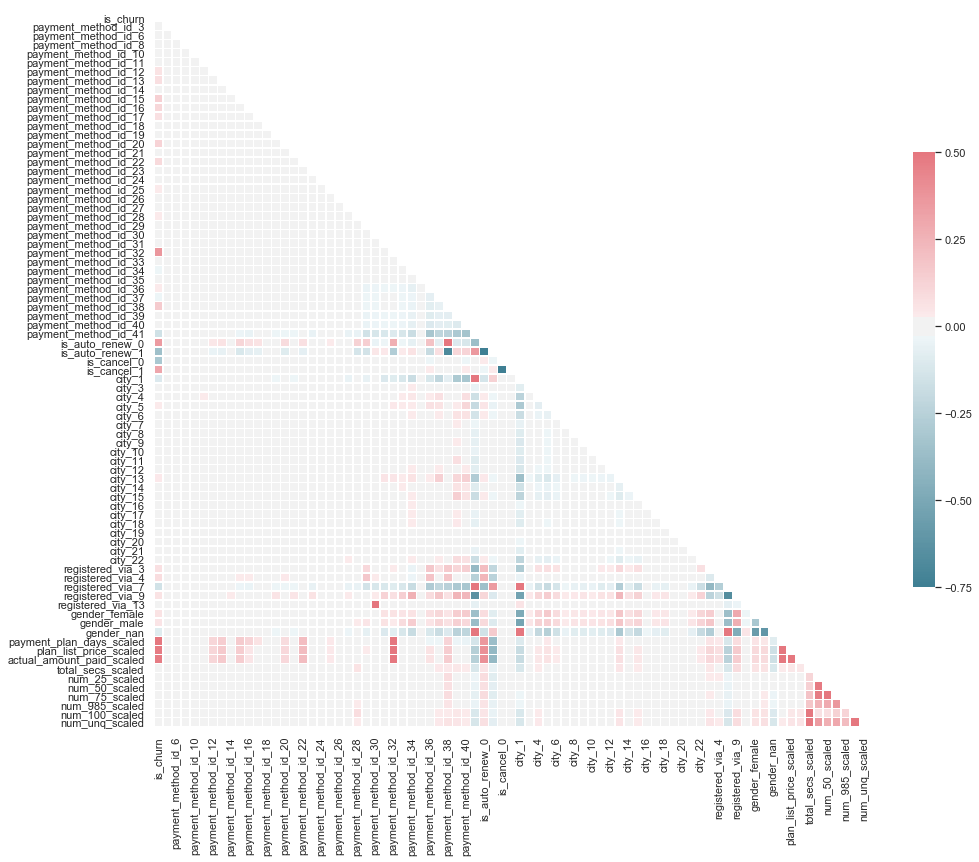

In [52]:
import seaborn as sns

def churn_correlation_heatmap(df):
    corr = df.corr()
    sns.set(style="whitegrid", palette="bright", color_codes=True)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(16, 16))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.75, vmax=.5, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()


columns = ['payment_method_id_3', 'payment_method_id_6',
           'payment_method_id_8', 'payment_method_id_10', 'payment_method_id_11',
           'payment_method_id_12', 'payment_method_id_13', 'payment_method_id_14',
           'payment_method_id_15', 'payment_method_id_16', 'payment_method_id_17',
           'payment_method_id_18', 'payment_method_id_19', 'payment_method_id_20',
           'payment_method_id_21', 'payment_method_id_22', 'payment_method_id_23',
           'payment_method_id_24', 'payment_method_id_25', 'payment_method_id_26',
           'payment_method_id_27', 'payment_method_id_28', 'payment_method_id_29',
           'payment_method_id_30', 'payment_method_id_31', 'payment_method_id_32',
           'payment_method_id_33', 'payment_method_id_34', 'payment_method_id_35',
           'payment_method_id_36', 'payment_method_id_37', 'payment_method_id_38',
           'payment_method_id_39', 'payment_method_id_40', 'payment_method_id_41',
           'is_auto_renew_0', 'is_auto_renew_1', 'is_cancel_0', 'is_cancel_1',
           'city_1', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8',
           'city_9', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14',
           'city_15', 'city_16', 'city_17', 'city_18', 'city_19', 'city_20',
           'city_21', 'city_22', 'registered_via_3', 'registered_via_4',
           'registered_via_7', 'registered_via_9', 'registered_via_13',
           'gender_female', 'gender_male', 'gender_nan',
           'payment_plan_days_scaled', 'plan_list_price_scaled',
           'actual_amount_paid_scaled', 'total_secs_scaled', 'num_25_scaled',
           'num_50_scaled', 'num_75_scaled', 'num_985_scaled', 'num_100_scaled',
           'num_unq_scaled']

churn_correlation_heatmap(my_train[columns])

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

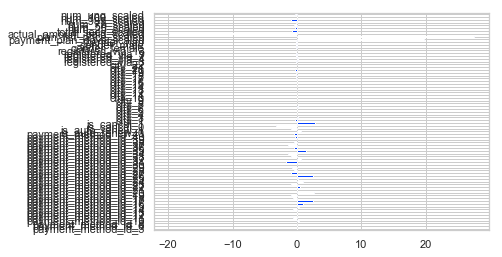

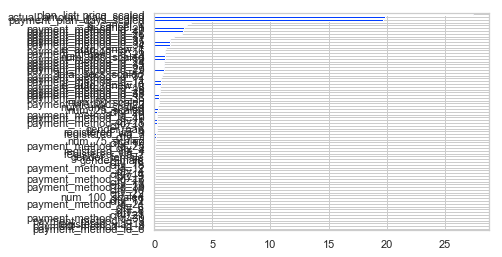

In [72]:
###***Coefficient Plot of all columns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

columns = ['payment_method_id_3', 'payment_method_id_6',
           'payment_method_id_8', 'payment_method_id_10', 'payment_method_id_11',
           'payment_method_id_12', 'payment_method_id_13', 'payment_method_id_14',
           'payment_method_id_15', 'payment_method_id_16', 'payment_method_id_17',
           'payment_method_id_18', 'payment_method_id_19', 'payment_method_id_20',
           'payment_method_id_21', 'payment_method_id_22', 'payment_method_id_23',
           'payment_method_id_24', 'payment_method_id_25', 'payment_method_id_26',
           'payment_method_id_27', 'payment_method_id_28', 'payment_method_id_29',
           'payment_method_id_30', 'payment_method_id_31', 'payment_method_id_32',
           'payment_method_id_33', 'payment_method_id_34', 'payment_method_id_35',
           'payment_method_id_36', 'payment_method_id_37', 'payment_method_id_38',
           'payment_method_id_39', 'payment_method_id_40', 'payment_method_id_41',
           'is_auto_renew_0', 'is_auto_renew_1', 'is_cancel_0', 'is_cancel_1',
           'city_1', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8',
           'city_9', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14',
           'city_15', 'city_16', 'city_17', 'city_18', 'city_19', 'city_20',
           'city_21', 'city_22', 'registered_via_3', 'registered_via_4',
           'registered_via_7', 'registered_via_9', 'registered_via_13',
           'gender_female', 'gender_male', 'gender_nan',
           'payment_plan_days_scaled', 'plan_list_price_scaled',
           'actual_amount_paid_scaled', 'total_secs_scaled', 'num_25_scaled',
           'num_50_scaled', 'num_75_scaled', 'num_985_scaled', 'num_100_scaled',
           'num_unq_scaled']

lr = LogisticRegression()
lr.fit(my_train[columns],my_train['is_churn'])

coefficients = lr.coef_

#1st plot (show distance)
feature_importance = pd.Series(coefficients[0], index=my_train[columns].columns)
feature_importance.plot.barh()
plt.show()

#2nd plot (sort feature_importance in order)
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

### Recursive Feature Elimination with Cross-Validation

In [63]:
from sklearn.feature_selection import RFECV

columns = ['payment_method_id_3', 'payment_method_id_6',
           'payment_method_id_8', 'payment_method_id_10', 'payment_method_id_11',
           'payment_method_id_12', 'payment_method_id_13', 'payment_method_id_14',
           'payment_method_id_15', 'payment_method_id_16', 'payment_method_id_17',
           'payment_method_id_18', 'payment_method_id_19', 'payment_method_id_20',
           'payment_method_id_21', 'payment_method_id_22', 'payment_method_id_23',
           'payment_method_id_24', 'payment_method_id_25', 'payment_method_id_26',
           'payment_method_id_27', 'payment_method_id_28', 'payment_method_id_29',
           'payment_method_id_30', 'payment_method_id_31', 'payment_method_id_32',
           'payment_method_id_33', 'payment_method_id_34', 'payment_method_id_35',
           'payment_method_id_36', 'payment_method_id_37', 'payment_method_id_38',
           'payment_method_id_39', 'payment_method_id_40', 'payment_method_id_41',
           'is_auto_renew_0', 'is_auto_renew_1', 'is_cancel_0', 'is_cancel_1',
           'city_1', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8',
           'city_9', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14',
           'city_15', 'city_16', 'city_17', 'city_18', 'city_19', 'city_20',
           'city_21', 'city_22', 'registered_via_3', 'registered_via_4',
           'registered_via_7', 'registered_via_9', 'registered_via_13',
           'gender_female', 'gender_male', 'gender_nan',
           'payment_plan_days_scaled', 'plan_list_price_scaled',
           'actual_amount_paid_scaled', 'total_secs_scaled', 'num_25_scaled',
           'num_50_scaled', 'num_75_scaled', 'num_985_scaled', 'num_100_scaled',
           'num_unq_scaled']

all_X = my_train[columns]
all_y = my_train['is_churn']
lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)

optimized_columns = all_X.columns[selector.support_]


C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

RFECV(cv=10,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [65]:
#Re-train the model with cross validation using the resulting 'optimized' columns and compare scores
optimized_columns = ['payment_method_id_10', 'payment_method_id_11', 'payment_method_id_12',
       'payment_method_id_13', 'payment_method_id_14', 'payment_method_id_15',
       'payment_method_id_16', 'payment_method_id_17', 'payment_method_id_18',
       'payment_method_id_19', 'payment_method_id_20', 'payment_method_id_22',
       'payment_method_id_23', 'payment_method_id_24', 'payment_method_id_25',
       'payment_method_id_26', 'payment_method_id_27', 'payment_method_id_28',
       'payment_method_id_29', 'payment_method_id_31', 'payment_method_id_32',
       'payment_method_id_33', 'payment_method_id_34', 'payment_method_id_35',
       'payment_method_id_36', 'payment_method_id_37', 'payment_method_id_38',
       'payment_method_id_39', 'payment_method_id_40', 'payment_method_id_41',
       'is_auto_renew_0', 'is_auto_renew_1', 'is_cancel_0', 'is_cancel_1',
       'city_1', 'city_3', 'city_4', 'city_7', 'city_16', 'city_17', 'city_18',
       'city_19', 'city_20', 'registered_via_3', 'registered_via_4',
       'registered_via_7', 'registered_via_9', 'gender_female', 'gender_male',
       'gender_nan', 'payment_plan_days_scaled', 'plan_list_price_scaled',
       'actual_amount_paid_scaled', 'total_secs_scaled', 'num_25_scaled',
       'num_50_scaled', 'num_75_scaled', 'num_985_scaled', 'num_100_scaled',
       'num_unq_scaled']

all_X = my_train[optimized_columns]
all_y = my_train['is_churn']
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
print("-------------------")
accuracy = scores.mean()

'''
Previous Results:  RFECV
(cv=10, estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)
'''

C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bunny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

-------------------


"\nPrevious Results:  RFECV\n(cv=10, estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n          intercept_scaling=1, max_iter=100, multi_class='warn',\n          n_jobs=None, penalty='l2', random_state=None, solver='warn',\n          tol=0.0001, verbose=0, warm_start=False),\n   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)\n"

In [67]:
#Results:  optimized_columns
print(scores) 
print("-------------------")
print(accuracy)

-------------------


array([0.96449093, 0.96502832, 0.96421534, 0.96442154, 0.964518  ,
       0.96511051, 0.96575814, 0.96588216, 0.96461445, 0.9647931 ])

-------------------


0.9648832484408789

In [ ]:
'''
Notes: optimized_columns =
      ['payment_method_id_10', 'payment_method_id_11', 'payment_method_id_12',
       'payment_method_id_13', 'payment_method_id_14', 'payment_method_id_15',
       'payment_method_id_16', 'payment_method_id_17', 'payment_method_id_18',
       'payment_method_id_19', 'payment_method_id_20', 'payment_method_id_22',
       'payment_method_id_23', 'payment_method_id_24', 'payment_method_id_25',
       'payment_method_id_26', 'payment_method_id_27', 'payment_method_id_28',
       'payment_method_id_29', 'payment_method_id_31', 'payment_method_id_32',
       'payment_method_id_33', 'payment_method_id_34', 'payment_method_id_35',
       'payment_method_id_36', 'payment_method_id_37', 'payment_method_id_38',
       'payment_method_id_39', 'payment_method_id_40', 'payment_method_id_41',
       'is_auto_renew_0', 'is_auto_renew_1', 'is_cancel_0', 'is_cancel_1',
       'city_1', 'city_3', 'city_4', 'city_7', 'city_16', 'city_17', 'city_18',
       'city_19', 'city_20', 'registered_via_3', 'registered_via_4',
       'registered_via_7', 'registered_via_9', 'gender_female', 'gender_male',
       'gender_nan', 'payment_plan_days_scaled', 'plan_list_price_scaled',
       'actual_amount_paid_scaled', 'total_secs_scaled', 'num_25_scaled',
       'num_50_scaled', 'num_75_scaled', 'num_985_scaled', 'num_100_scaled',
       'num_unq_scaled'], dtype='object'

scores:  array([0.96449093, 0.96502832, 0.96421534, 0.96442154, 0.964518,
                0.96511051, 0.96575814, 0.96588216, 0.96461445, 0.9647931 ])

accuracy:  0.9648832484408789
'''

In [69]:
0.9648832484408789 - 0.9648777367302165

5.5117106624313905e-06

In [ ]:
# To ignore FutureWarning messages:
''' Prior to running the kernel, include the specs below. 
    Option 1)
        import warnings
        warnings.filterwarnings("ignore", category=FutureWarning)
    Option 2)
        LogisticRegression(solver='lbfgs')
'''